[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Masao-Taketani/gan_practice/blob/master/dcgan.ipynb)


# The Difference Between WGAN and WGAN-GP
- uses gradient penalty in the critic loss
- does not clip the weights of the critic
- does not use Batch Normalization layers in the critic

In [11]:
!pip install --upgrade tensorflow==1.15

     |████████████████████████████████| 412.3MB 34kB/s 
     |████████████████████████████████| 512kB 36.4MB/s 
     |████████████████████████████████| 3.8MB 44.3MB/s 
  Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [0]:
!export TF_ENABLE_AUTO_MIXED_PRECISION=1

In [0]:
from glob import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,\
Activation, Dropout, Flatten, Dense, Reshape, UpSampling2D, LeakyReLU,\
ZeroPadding2D, Layer
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [0]:
# hyper params
num_data = 20579
img_size = 128
channel_size = 3
batch_size = 32

input_dims = (img_size, img_size, channel_size)
num_critic_layers = 4
critic_conv_fils = [32, 64, 128, 256]
critic_conv_kernel_size = [3, 3, 3, 3]
critic_conv_strides = [2, 2, 2, 1]
critic_batch_norm_momentum = 0.8
critic_dropout_rate = 0.25

z_dims = 100
shape_after_dense = (img_size//4, img_size//4, 128)
gen_upsamp_layers = [True, True, False]
gen_batch_norm_momentum = 0.8
gen_dropout_rate = None
num_gen_layers = 3
gen_conv_fils = [128, 64, channel_size]
gen_conv_kernel_size = [3, 3, 3]

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
!tar -zxvf drive/My\ Drive/datasets/gan/dogs_data/tfrecords/tfrecords_as_one.tar.gz

tfrecords/
tfrecords/whole_dogs_data.tfrecord
tfrecords/.gitkeep


In [0]:
data_path = "tfrecords/whole_dogs_data.tfrecord"

In [0]:
def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([img_size * img_size * channel_size], dtype=tf.float32)
        })
    
    X = features['X']
    
    return X


def iterator(tfrecord_path, num_data):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(num_data)
    iterator = dataset.make_one_shot_iterator()

    X = iterator.get_next()
    X = tf.reshape(X, [-1, img_size, img_size, channel_size])
    
    return X

In [12]:
x_train = iterator(data_path, num_data)
x_train = tf.Session().run(x_train)
x_train.shape

(20579, 128, 128, 3)

## Interpolated Images for GP Loss

In [0]:
class RandomWeightedAverageImgs(Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        
    def call(self, inputs, **kwargs):
        alpha = tf.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

## Critic

In [14]:
critic_input = Input(shape=input_dims, name="critic_input")
x = critic_input

for i in range(num_critic_layers):
    x = Conv2D(filters=critic_conv_fils[i],
              kernel_size=critic_conv_kernel_size[i],
              strides=critic_conv_strides[i],
              padding="same",
              name="critic_conv_" + str(i)
              )(x)
    
    if i == 1:
        """
        Arguments:
        padding: Int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
        If int: the same symmetric padding is applied to height and width.
        If tuple of 2 ints: interpreted as two different symmetric padding
            values for height and width: (symmetric_height_pad, symmetric_width_pad).
        If tuple of 2 tuples of 2 ints: interpreted 
            as ((top_pad, bottom_pad), (left_pad, right_pad))
        """
        x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
        
    if critic_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum=critic_batch_norm_momentum)(x)
        
    x = LeakyReLU(alpha=0.2)(x)
    
    if critic_dropout_rate:
        x = Dropout(critic_dropout_rate)(x)
    
x = Flatten()(x)
critic_output = Dense(1, activation=None)(x)
critic_model = Model(critic_input, critic_output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
critic_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 33, 33, 64)        256   

## Generator

In [0]:
gen_input = Input(shape=(z_dims,), name="gen_input")
x = gen_input
x = Dense(np.prod(shape_after_dense))(x)
x = Activation("relu")(x)
x = Reshape(shape_after_dense)(x)
for i in range(num_gen_layers):
    if gen_upsamp_layers[i]:
        x = UpSampling2D()(x)
        
    x = Conv2D(gen_conv_fils[i],
              gen_conv_kernel_size[i],
              padding="same",
              name="gen_conv_" + str(i)
              )(x)
    
    if i < num_gen_layers - 1:
        if gen_batch_norm_momentum:
            x = BatchNormalization(
            momentum=gen_batch_norm_momentum)(x)
            
        x = Activation("relu")(x)
    else:
        x = Activation("tanh")(x)
        
gen_output = x
gen_model = Model(gen_input, gen_output)

In [17]:
gen_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            13238272  
_________________________________________________________________
activation (Activation)      (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
gen_conv_0 (Conv2D)          (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 128)       512 

## Wasserstein Loss

In [0]:
def wasserstein(y_true, y_pred):
    return K.mean(y_true * y_pred)

# GP Loss  (![CodeCogsEqn](https://user-images.githubusercontent.com/37681936/74709815-710ae200-5263-11ea-9c3d-dd650da0467f.png))

In [0]:
def gradient_penalty(y_true, y_pred, interpolated_samples):
    # gradients(loss, variables)
    # returns the gradients of the loss wrt the variables
    gradients = K.gradients(y_pred, interpolated_samples)[0]
    gradient_l2_norm = K.sqrt(K.sum(
                                K.square(gradients),
                                axis=np.arange(1, len(gradients.shape))
                                   )
                              )
    # squared distance between the l2 nrom and 1
    gradient_penalty = K.square(gradient_l2_norm - 1)
    return K.mean(gradient_penalty)

## Critic Train Model

In [20]:
gen_model.trainable = False
real_imgs = Input(input_dims)
gen_inputs = Input((z_dims,))
fake_imgs = gen_model(gen_inputs)

real_pred = critic_model(real_imgs)
fake_pred = critic_model(fake_imgs)

interpolated_imgs = RandomWeightedAverageImgs(batch_size)(
                      [real_imgs, fake_imgs])
interpolated_pred = critic_model(interpolated_imgs)

gp = partial(gradient_penalty, interpolated_samples=interpolated_imgs)
gp.__name__ = "gradient_penalty"

critic_train_model = Model([real_imgs, gen_inputs],
                     [real_pred, fake_pred, interpolated_pred])
critic_train_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 3)  13462147    input_2[0][0]                    
__________________________________________________________________________________________________
random_weighted_average_imgs (R (32, 128, 128, 3)    0           input_1[0][0]                    
                                                                 model_1[1][0]             

In [0]:
plot_model(critic_train_model, to_file="model_imgs/wgan-gp_critic_model.png", \
           show_shapes=True)

### Compile the Critic Train Model

In [23]:
critic_train_model.compile(#optimizer=RMSprop(lr=0.00005),
                  optimizer=tf.train.experimental.enable_mixed_precision_graph_rewrite(Adam(0.0002, 0.5)),
                  loss=[wasserstein, wasserstein, gp],
                  loss_weights=[1, 1, 10])

## Generator Train Model

In [24]:
critic_model.trainable = False
gen_model.trainable = True

gen_train_inputs = Input((z_dims,))
critic_pred = critic_model(gen_model(gen_train_inputs))
gen_train_model = Model(gen_train_inputs, critic_pred)
gen_train_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       13462147  
_________________________________________________________________
model (Model)                multiple                  464193    
Total params: 13,926,340
Trainable params: 13,461,763
Non-trainable params: 464,577
_________________________________________________________________


### Compile the Generator Train Model

In [25]:
gen_train_model.compile(optimizer=tf.train.experimental.enable_mixed_precision_graph_rewrite(Adam(0.0002, 0.5)),
                        loss=wasserstein)

critic_model.trainable = True

## Train the WGAN-GP

### !!! need to keep implementing from here !!!

In [0]:
def train_critic(critic_train_model, gen_train_model, x_train, batch_size):
    # create 2-dim labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = -np.ones((batch_size, 1))
    # dummy labels for GP
    dummy_labels = np.zeros((batch_size, 1), dtype=np.float32)
    
    # train on real imgs
    # np.random.randint(min, max, size)
    idxes = np.random.randint(0, len(x_train), batch_size)
    real_imgs = x_train[idxes]
    
    # train on fake imgs
    # np.random.normal(mean, std, size)
    # the blow follows the standard normal distribution
    noises = np.random.normal(0, 1, (batch_size, z_dims))
    
    critic_loss = critic_train_model.train_on_batch(
                            [real_imgs, noises],
                            [real_labels, fake_labels, dummy_labels])

    return critic_loss


def train_gen(gen_train_model, batch_size):
    real_labels = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    gen_loss = gen_train_model.train_on_batch(noise, real_labels)
    return gen_loss


def plot_generated_imgs(rows, cols, noises, it, gen_model):
    print("iteration: ", it)

    gen_imgs = gen_model.predict(noises)

    # since gen model outputs values ranging from -1 to 1,
    # nomalize imgs ranging from 0 to 1
    #=====================================================================
    # matplotlib.pyplot.imshow(..., norm=None, ...):
    # By default, a linear scaling mapping the lowest value to 0 and
    # the highest to 1 is used. This parameter is ignored for RGB(A) data.
    #=====================================================================

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(rows, cols)

    ith_img = 0
    for row in range(rows):
        for col in range(cols):
            try:
                axs[row, col].imshow(gen_imgs[ith_img,:,:,:])
                axs[row, col].axis("off")
                ith_img += 1
            except IndexError:
                axs[col].imshow(gen_imgs[ith_img,:,:,:])
                axs[col].axis("off")
                ith_img += 1

[training log]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
iteration: 0 critic_ loss: 18.185 (R:0.64, F:-1.47, D:1.90) gen loss: 1.853
iteration:  0
iteration: 1000 critic_ loss: -12.272 (R:39.88, F:-54.68, D:0.25) gen loss: 54.919
iteration:  1000
iteration: 2000 critic_ loss: -7.979 (R:42.60, F:-51.49, D:0.09) gen loss: 50.330
iteration:  2000
iteration: 3000 critic_ loss: -6.150 (R:79.66, F:-91.29, D:0.55) gen loss: 91.805
iteration:  3000
iteration: 4000 critic_ loss: -0.954 (R:66.58, F:-67.69, D:0.02) gen loss: 67.398
iteration:  4000
iteration: 5000 critic_ loss: 2.635 (R:70.49, F:-68.46, D:0.06) gen loss: 70.733
iteration:  5000
iteration: 6000 critic_ loss: -6.126 (R:94.10, F:-100.74, D:0.05) gen loss: 100.306
iteration:  6000
iteration: 7000 critic_ loss: -3.961 (R:98.67, F:-102.91, D:0.03) gen loss: 102.297
iteration:  7000
iteration: 8000 critic_ loss: -0.485 (R:66.88, F:-67.48, D:0.01) gen loss: 70.058
iteration:  8000
itera

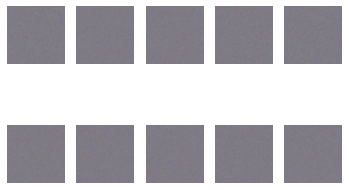

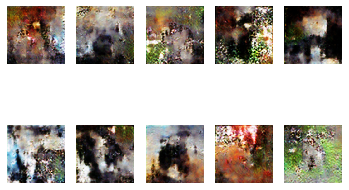

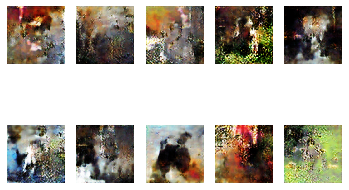

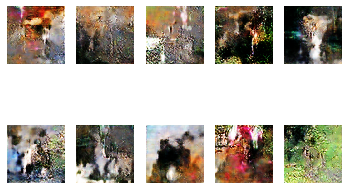

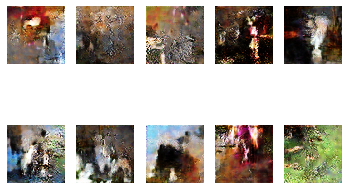

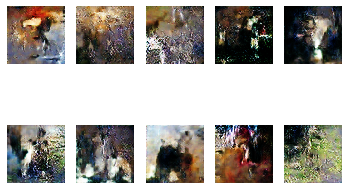

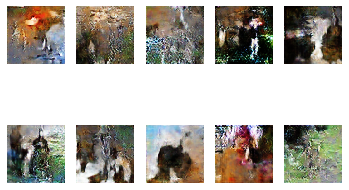

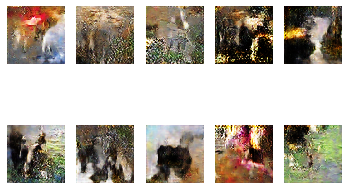

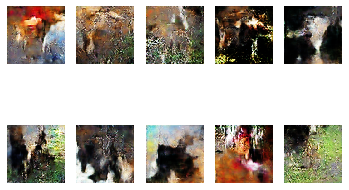

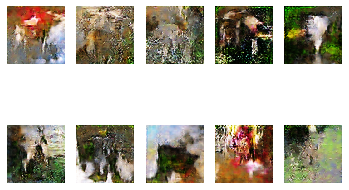

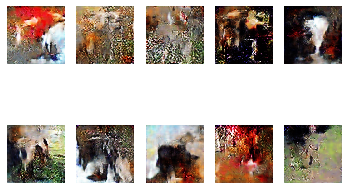

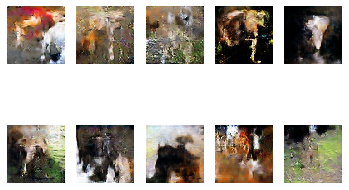

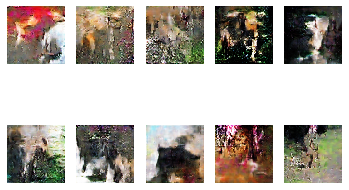

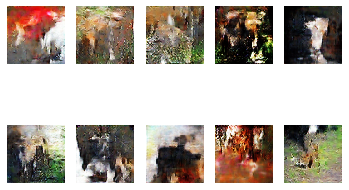

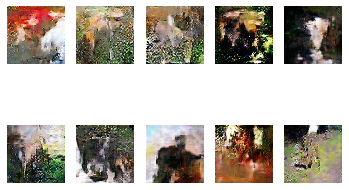

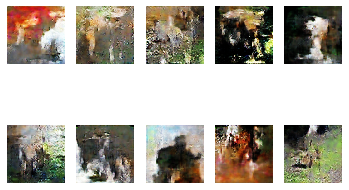

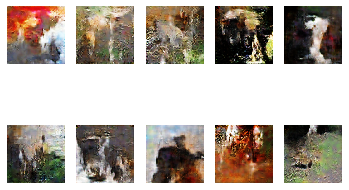

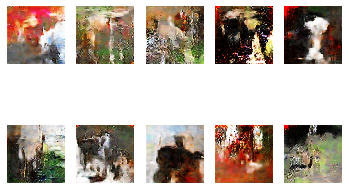

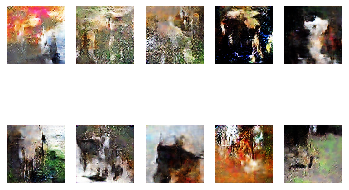

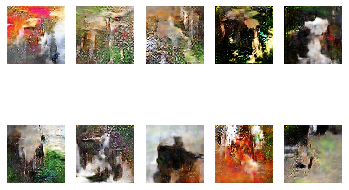

In [27]:
iterations = 20_000
rows, cols = 2, 5
noises = np.random.normal(0, 1, (rows * cols, z_dims))

print("[training log]")
for it in range(iterations):

    for i in range(5):
        if i == 4:
            critic_loss = train_critic(critic_train_model,
                                       gen_train_model,
                                       x_train,
                                       batch_size)
        else:
            _ = train_critic(critic_train_model,
                                       gen_train_model,
                                       x_train,
                                       batch_size)
    
    gen_loss = train_gen(gen_train_model, batch_size)
    
    if it % 1000 == 0:
        print("iteration: %d critic_ loss: %.3f (R:%.2f, F:%.2f, D:%.2f) "
        "gen loss: %.3f" % 
          (it, critic_loss[0], critic_loss[1], critic_loss[2], \
           critic_loss[3], gen_loss))
        plot_generated_imgs(rows, cols, noises, it, gen_model)
        
print("[10 generated images for each 1000th iteration]")